#**Business Problem**问题描述
Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

The long-term goal is to develop a classfier to predict whether a patient will suffer from cirrhosis or not. In the M2 hackathon your task is to complete data preparation and feature engineering components of the workflow.

肝硬化是肝脏瘢痕形成(纤维化)的晚期阶段，由多种形式的肝脏疾病和病症(如肝炎和慢性酒精中毒)引起。以下数据来自梅奥诊所在1974年至1984年间进行的原发性胆汁性肝硬化(PBC)试验。

在这10年期间，共有424名PBC患者转至梅奥诊所，符合药物d -青霉胺随机安慰剂对照试验的资格标准。数据集中的前312例患者参与了随机试验，数据基本完整。另外112例患者没有参加临床试验，但同意记录基本测量数据，并对其进行随访。其中6例在诊断后不久就失去了随访，所以这里的数据是额外的106例病例以及312名随机参与者。

长期目标是开发一种分类器来预测患者是否会患上肝硬化。这份文件的任务是完成工作流的数据准备和特征工程组件。

![cirr info](https://preferredresearchpartners.com/build/wp-content/uploads/2017/11/Cirrhosis-fact-sheet-PRP.jpg)

#**Summary工作总结**

1. Execute the following data preparation action items:
> * 排除无关变量Drop ID feature
> * 处理缺失值 Address the NaNs in most of the categorical features: **We drop the NaNs in all lines. We tried to fill NAs with the majority data but the code has some problems.**
> * 对类别数据进行编码 Encode the Stage feature: **We used the dummy encode to encode the category features.**
> * Address any remaining outliers in the features: **We winsorized the outliers and the index is 0.25 and 0.75.**
> * 矫正部分变量的偏度 Correct skewness in Bilirubin, Cholesterol, SGOT, Copper, Alk_Phos, and Tryglicerides features: **We used the function to deal with the skewness features that is less than-1 and greater than1.**
> * 创建目标变量并进行编码 Create a new Target variable such that Target = 1 if Stage is 3 or 4, and Target = 0 of Stage = 1 or 2. **We created a new column called Target and complete it.**
> * 处理数据集不平衡问题 Address imbalance in the Target variable: **First we checked the data imbalance situation and used oversampling method to rebalance the data because the amount of data is too samll so it is not so good to use undersampling.**

2. 评估特征重要性 Assess feature importance. 
**The graph showed that Prothrombin, Bilirubin, N_Days are important features.**
3. 进行RFE和PCA处理观察变量 Is RFE or PCA relevant to your dataset? 
**The PCA result showed that 2 variables will be fine for our model because the sum of the PC1 and PC2 is near 1.**

#**Libraries**

In [ ]:
#!pip install -q pycaret autoviz --upgrade psynlig
#from pycaret.classification import *

In [ ]:
#from autoviz.AutoViz_Class import AutoViz_Class

In [ ]:
# Basic libraries
%matplotlib inline
import pandas as pd
from psynlig import pca_explained_variance_bar
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as ss
import math
from matplotlib.colors import ListedColormap

In [ ]:
# sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss, balanced_accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

In [ ]:
# mblearn library
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

#**Data Dictionary**
1) ID: unique identifier

2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986

3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)

4) Drug: type of drug D-penicillamine or placebo

5) Age: age in [days]

6) Sex: M (male) or F (female)

7) Ascites: presence of ascites N (No) or Y (Yes)

8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)

9) Spiders: presence of spiders N (No) or Y (Yes)

10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)

11) Bilirubin: serum bilirubin in [mg/dl]

12) Cholesterol: serum cholesterol in [mg/dl]

13) Albumin: albumin in [gm/dl]

14) Copper: urine copper in [ug/day]

15) Alk_Phos: alkaline phosphatase in [U/liter]

16) SGOT: SGOT in [U/ml]

17) Triglycerides: triglicerides in [mg/dl]

18) Platelets: platelets per cubic [ml/1000]

19) Prothrombin: prothrombin time in seconds [s]

20) Stage: histologic stage of disease (1, 2, 3, or 4)

#**Data**

In [ ]:
# Read
# File: https://drive.google.com/file/d/18eEu3LBKhRi1lY6n8Ch5saoeqKSuaGb-/view?usp=share_link
url = 'https://drive.google.com/uc?id=18eEu3LBKhRi1lY6n8Ch5saoeqKSuaGb-'

# Read in the dataset
df = pd.read_csv(url)

#**M2: Exploratory Data Analysis**

In [ ]:
df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [ ]:
# Shape of df
print("Shape", df.shape)

# Check data types
print(df.info())

Shape (418, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64

In [ ]:
df.columns

Index(['ID', 'N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites',
       'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol',
       'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets',
       'Prothrombin', 'Stage'],
      dtype='object')

In [ ]:
df.head()


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [ ]:
# Feature Types
quant_features = ['Age',
       'N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categorical_features = ['Drug','Sex','Ascites','Hepatomegaly', 'Spiders', 'Edema', 'Status']
target = ['Stage']


In [ ]:
# get unique values of the target ('Credit_Score')
for feature in ['Status']:
  unique_values = df[feature].unique()
  print(feature,unique_values)

Status ['D' 'C' 'CL']


In [ ]:
# count NaNs
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [ ]:
# Identify duplicates (dups)
df.duplicated().sum()

0

In [ ]:
# summary
df.describe()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,209.500000,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,120.810458,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,1.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,105.250000,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,209.500000,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,313.750000,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,418.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


In [ ]:
#Skewness
df[quant_features].skew()

Age              0.086850
N_Days           0.472602
Bilirubin        2.717611
Cholesterol      3.408526
Albumin         -0.467527
Copper           2.303640
Alk_Phos         2.992834
SGOT             1.449197
Tryglicerides    2.523902
Platelets        0.627098
Prothrombin      2.223276
dtype: float64

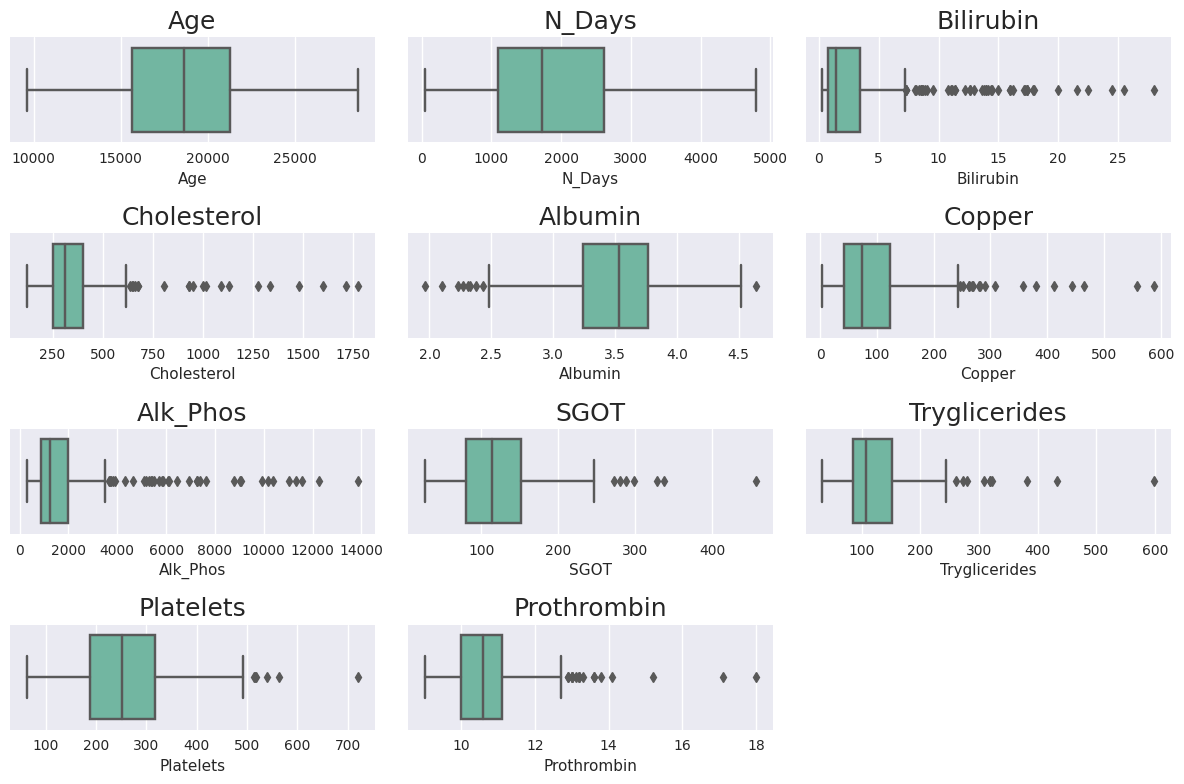

In [ ]:
#Box Plots
%matplotlib inline
plt.figure(figsize=(12,8))
j=1
for i in quant_features:
    plt.subplot(4,3,j)
    sns.set_palette('Set2')
    sns.boxplot(x=df[i],data=df,orient="v")
    sns.despine(top=True,right=True,left=True)
    plt.tight_layout()
    plt.title(i,size = 18)
    j=j+1

In [ ]:
# create an AutoViz class
#AV = AutoViz_Class()

In [ ]:
# create charts
#dftc = AV.AutoViz(filename='', sep ='' , depVar = 'Stage', dfte = df, header = 0,
#verbose = 1, lowess = False, chart_format ='png', max_rows_analyzed = 15000, max_cols_analyzed = 30)

# **M3: Preprocessing**数据预处理过程
The M3 Hackathon begins here. Enjoy!

## Drop ID feature

In [ ]:
df = df.drop(columns='ID')
df

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


## Address the NaNs in most of the categorical features

In [ ]:
df = df.dropna()
df

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1153,C,D-penicillamine,22347,F,N,Y,N,N,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0
308,994,C,Placebo,21294,F,N,N,N,N,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0
309,939,C,D-penicillamine,22767,F,N,N,N,N,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0
310,839,C,D-penicillamine,13879,F,N,N,N,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0


## Create a new Target variable


In [ ]:
import pandas as pd
#Encode the features
df['Target'] = df['Stage'].apply(lambda x: 1 if x in [3, 4] else 0)
df['Drug']=df['Drug'].apply(lambda x: 0 if x in ['Placebo'] else 1)
df['Sex']=df['Sex'].apply(lambda x: 0 if x in ['F'] else 1)
df['Ascites']=df['Ascites'].apply(lambda x: 0 if x in ['Y'] else 1)
df['Hepatomegaly']=df['Hepatomegaly'].apply(lambda x: 0 if x in ['Y'] else 1)
df['Spiders']=df['Spiders'].apply(lambda x: 0 if x in ['Y'] else 1)
df['Edema'] = df['Edema'].apply(lambda x: 
                                0 if x == 'Y' else 
                                1 if x == 'N' else 
                                2 if x == 'S' else x)
df['Status'] = df['Status'].apply(lambda x: 
                                0 if x == 'D' else 
                                1 if x == 'C' else 
                                2 if x == 'CL' else x)

## Encode the Stage feature

In [ ]:
#df = pd.get_dummies(data=df, columns=['Drug','Sex','Ascites','Hepatomegaly', 'Spiders', 'Edema', 'Status','Stage'],drop_first=True)
#df = df.drop(df.iloc[:,-1])
#df

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y,Status_CL,Status_D,Stage_2.0,Stage_3.0,Stage_4.0
0,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,...,1,1,1,0,1,0,1,0,0,1
1,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,...,0,1,1,0,0,0,0,0,1,0
2,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,...,0,0,0,1,0,0,1,0,0,1
3,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,...,0,1,1,1,0,0,1,0,0,1
4,1504,13918,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,...,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1153,22347,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,...,0,1,0,0,0,0,0,1,0,0
308,994,21294,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,...,0,0,0,0,0,0,0,1,0,0
309,939,22767,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,...,0,0,0,0,0,0,0,1,0,0
310,839,13879,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,...,0,0,0,0,0,0,0,1,0,0


## Correct skewness in Bilirubin, Cholesterol, SGOT, Copper, Alk_Phos, and Tryglicerides features

In [ ]:
#Skewness
df[quant_features].skew()

Age              0.180645
N_Days           0.402023
Bilirubin        2.844267
Cholesterol      3.361881
Albumin         -0.597403
Copper           2.266390
Alk_Phos         3.035066
SGOT             1.472092
Tryglicerides    2.541331
Platelets        0.373843
Prothrombin      1.809612
dtype: float64

In [ ]:
#Correct skewness 
#Code for skewness correction (see source below)
#Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""
Created on Sat Feb 23 14:42:46 2019
@author: DATAmadness
"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness

# Further documentation available here:
# https://datamadness.github.io/Skewness_Auto_Transform

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
                

    return DF

In [ ]:
df.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Target'],
      dtype='object')

In [ ]:
# Feature Types
quant_features = ['Age',
       'N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categorical_features = ['Drug','Sex','Ascites','Hepatomegaly', 'Spiders', 'Edema', 'Status']
target = ['Stage']
# Split features into X1 (quant features), X2 (qual features) and y (target)
# Identify predictors & target
X1 = df[['Age',
       'N_Days', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']]
X2 = df[['Drug','Sex','Ascites','Hepatomegaly', 'Spiders', 'Edema', 'Status']]
y = df['Target']


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'N_Days' . Skewness = 0.40


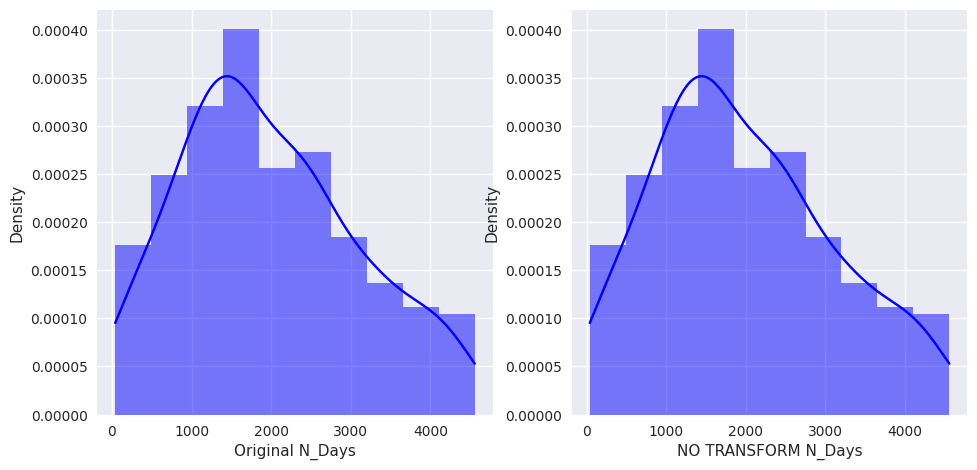


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'Age' . Skewness = 0.18


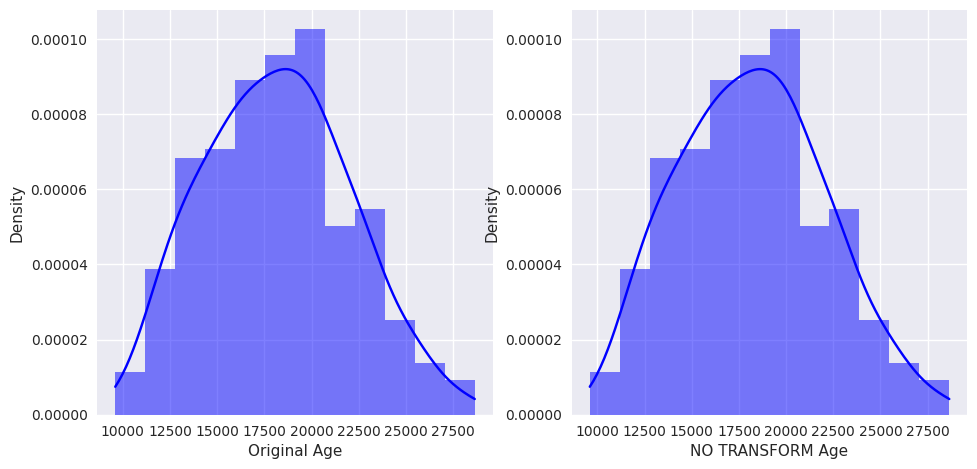


 ------------------------------------------------------

 'Bilirubin' had 'positive' skewness of 2.84

 Transformation yielded skewness of 0.09


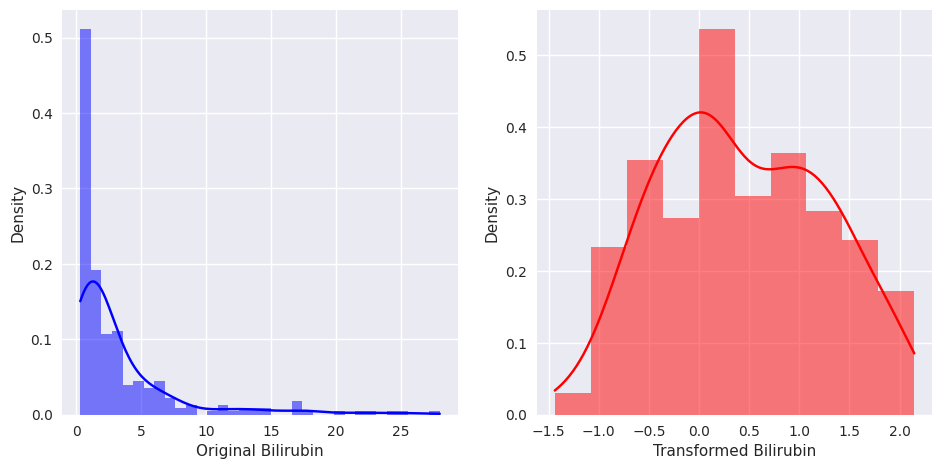


 ------------------------------------------------------

 'Cholesterol' had 'positive' skewness of 3.36

 Transformation yielded skewness of -0.05


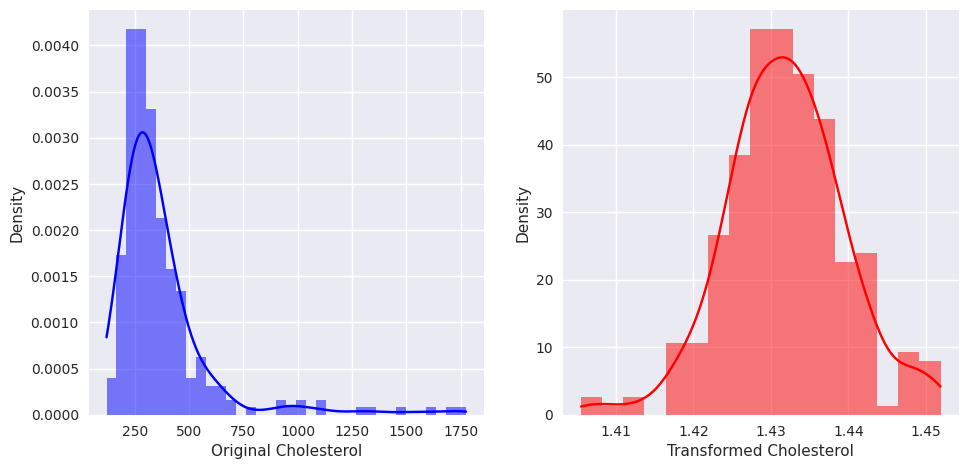


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'Albumin' . Skewness = -0.60


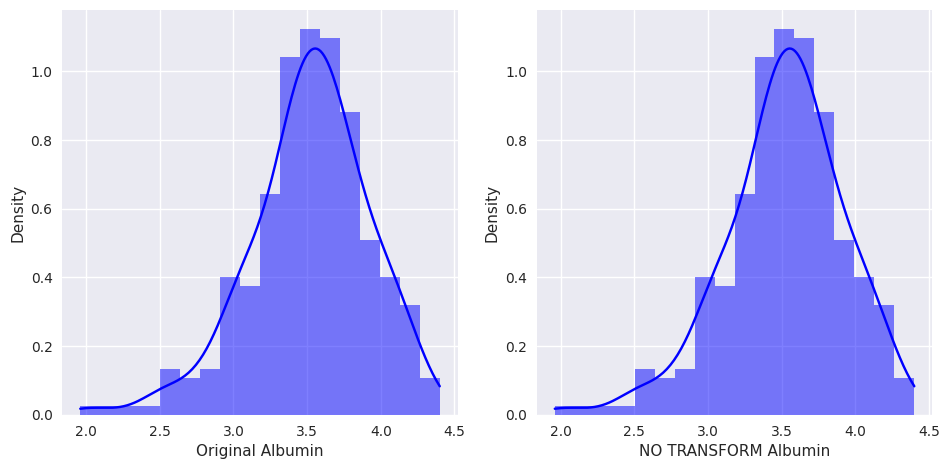


 ------------------------------------------------------

 'Copper' had 'positive' skewness of 2.27

 Transformation yielded skewness of 0.00


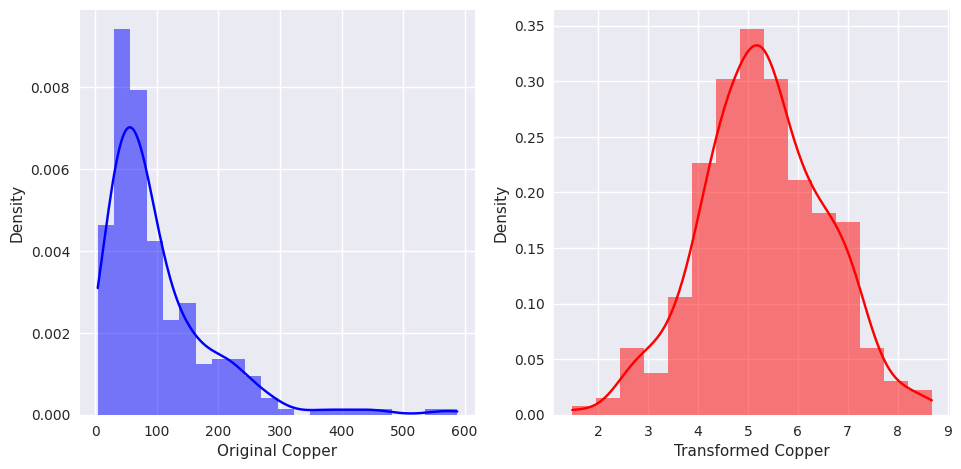


 ------------------------------------------------------

 'Alk_Phos' had 'positive' skewness of 3.04

 Transformation yielded skewness of 0.00


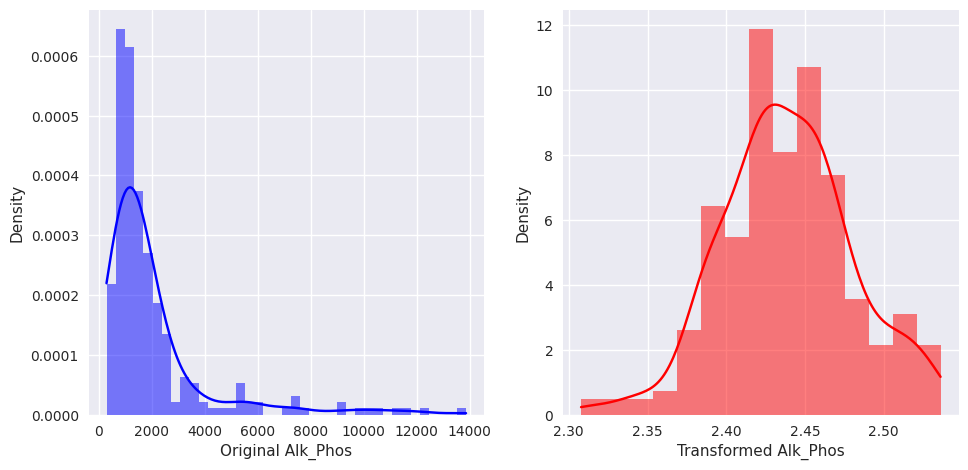


 ------------------------------------------------------

 'SGOT' had 'positive' skewness of 1.47

 Transformation yielded skewness of -0.00


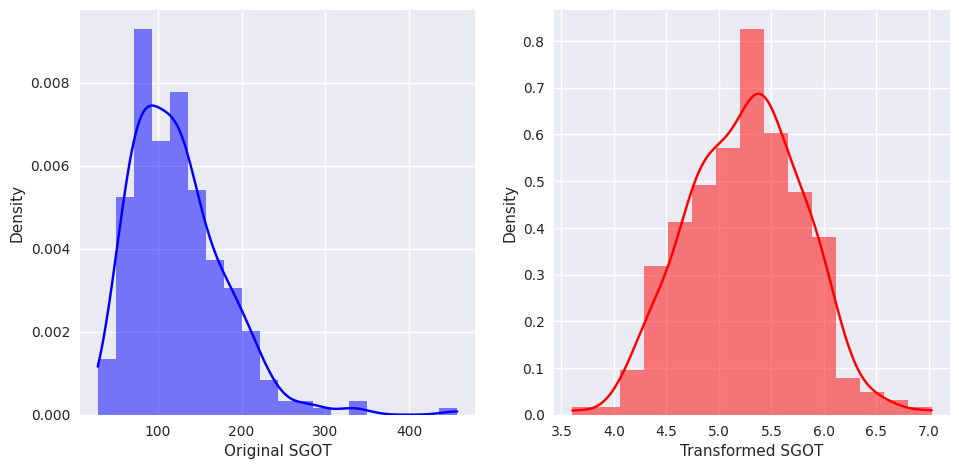


 ------------------------------------------------------

 'Tryglicerides' had 'positive' skewness of 2.54

 Transformation yielded skewness of -0.00


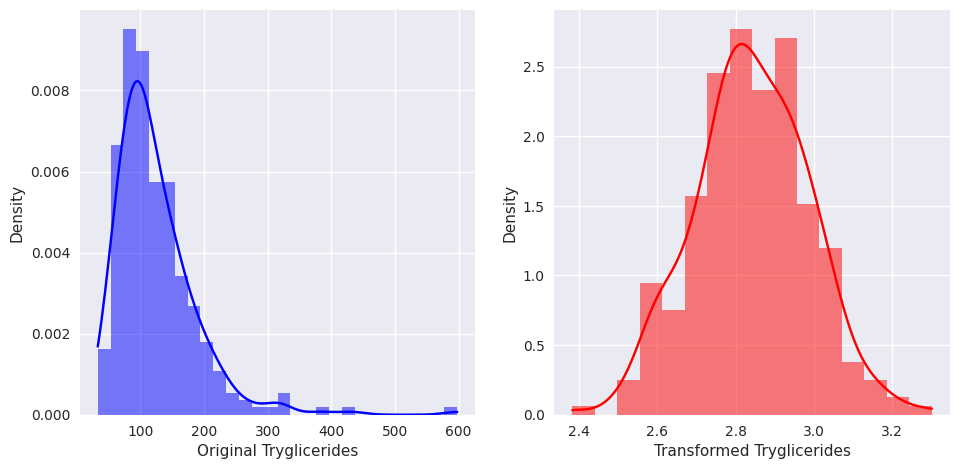


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'Platelets' . Skewness = 0.37


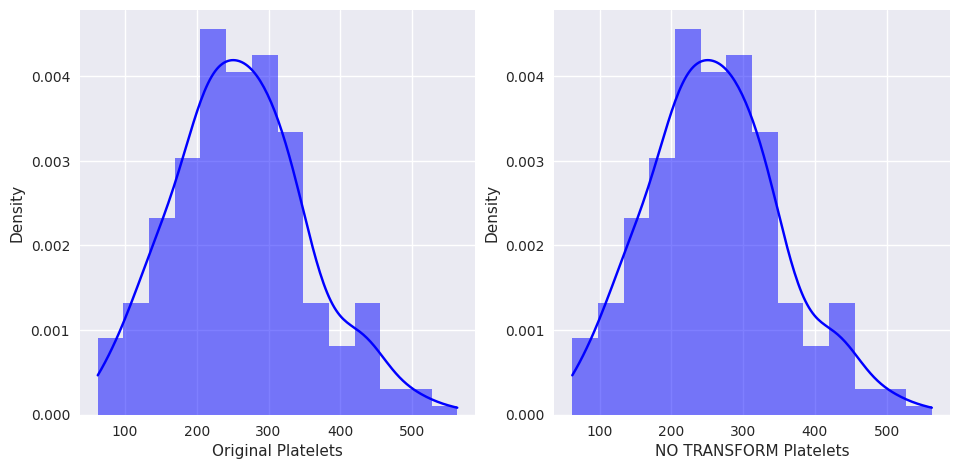


 ------------------------------------------------------

 'Prothrombin' had 'positive' skewness of 1.81

 Transformation yielded skewness of 0.00


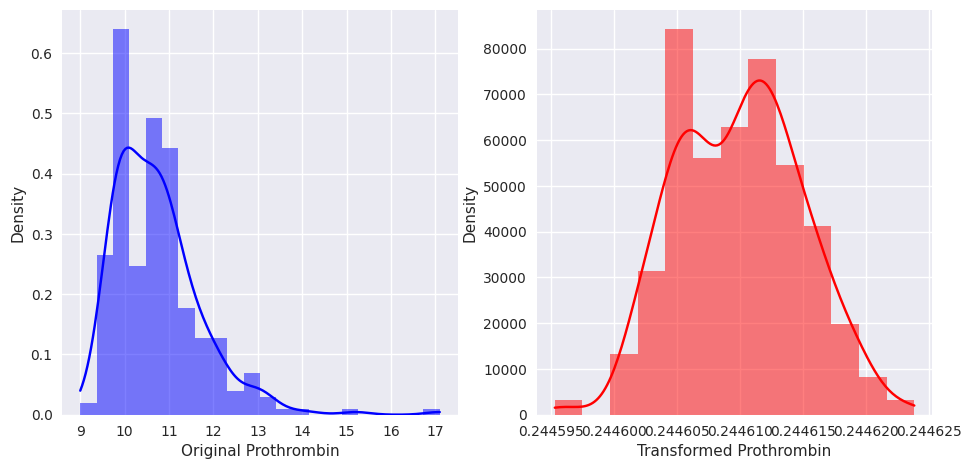

In [ ]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
X = skew_autotransform(X1.copy(deep=True), include=['N_Days','Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper','Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'],plot = True, exp = False, threshold = 1)


In [ ]:
X = pd.concat([X,X2],axis=1,join="inner")

In [ ]:
X

,Age,N_Days,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,21464,400,1.867491,1.428240,2.60,6.434539,2.454109,5.499779,2.981776,190.0,0.244617,1,0,0,0,0,0,0
1,20617,4500,0.094020,1.431316,4.14,4.823270,2.517979,5.258877,2.765973,221.0,0.244610,1,0,1,0,0,1,1
2,25594,1012,0.320749,1.418220,3.48,6.915063,2.366701,5.054608,2.592951,151.0,0.244617,1,1,1,1,1,2,0
3,19994,1925,0.540920,1.426713,2.54,5.070814,2.511585,4.497534,2.781367,183.0,0.244608,1,0,1,0,0,2,0
4,13918,1504,1.032107,1.429685,3.53,6.296359,2.389374,5.254860,2.694438,136.0,0.244612,0,0,1,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,22347,1153,-1.047944,1.426902,3.58,3.693824,2.403035,4.988067,2.850505,288.0,0.244609,1,0,1,0,1,1,1
308,21294,994,-1.047944,1.428155,2.75,4.430156,2.430217,4.670133,2.741184,231.0,0.244611,0,0,1,1,1,1,1
309,22767,939,0.492230,1.437754,3.35,4.359840,2.453942,5.767622,2.809810,234.0,0.244608,1,0,1,1,1,1,1
310,13879,839,0.628606,1.426996,3.16,5.181662,2.423122,5.296062,2.765973,335.0,0.244610,1,0,1,1,1,1,1


In [ ]:
#Skewness
X[quant_features].skew()

Age              0.180645
N_Days           0.402023
Bilirubin        0.090297
Cholesterol     -0.046934
Albumin         -0.597403
Copper           0.001151
Alk_Phos         0.002459
SGOT            -0.000801
Tryglicerides   -0.002467
Platelets        0.373843
Prothrombin      0.000000
dtype: float64

## Address any remaining outliers in the features

Column  Age :  []
Column  N_Days :  []
Column  Bilirubin :  []
Column  Cholesterol :  [62, 75, 94, 95, 112, 145, 175, 213]
Column  Albumin :  [0, 3, 27, 64, 134, 190, 198, 232, 245]
Column  Copper :  [15, 20, 141]
Column  Alk_Phos :  [197, 206, 262]
Column  SGOT :  [6, 145]
Column  Tryglicerides :  [64, 163, 212]
Column  Platelets :  [36, 39, 174]
Column  Prothrombin :  [148]
Column  Drug :  []
Column  Sex :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 1

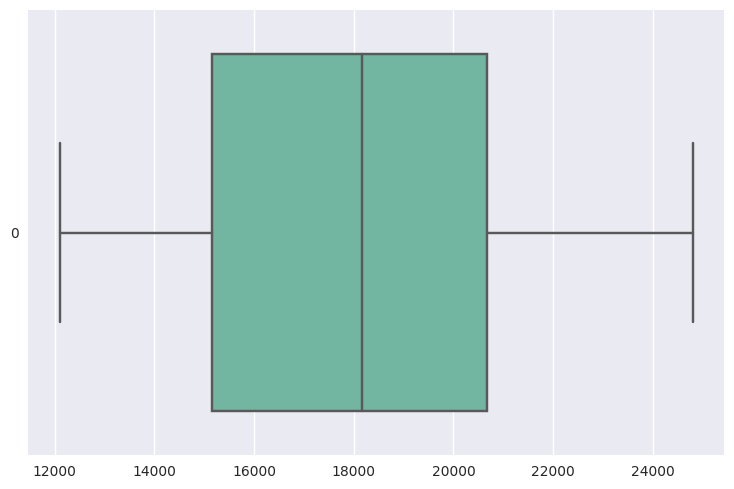

Column  N_Days


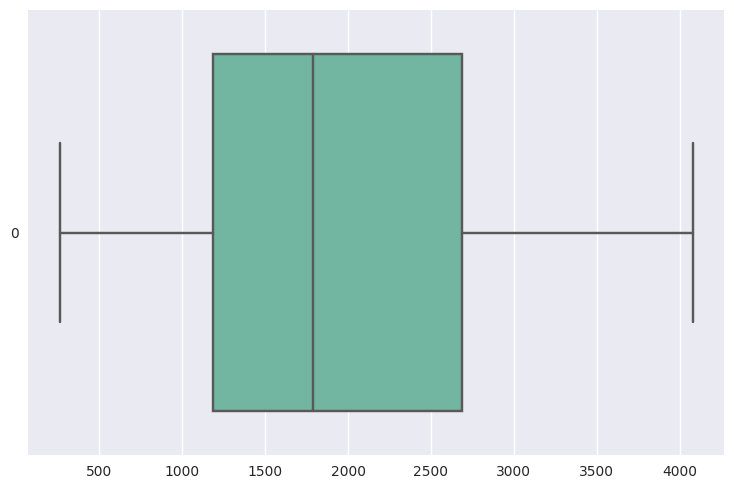

Column  Bilirubin


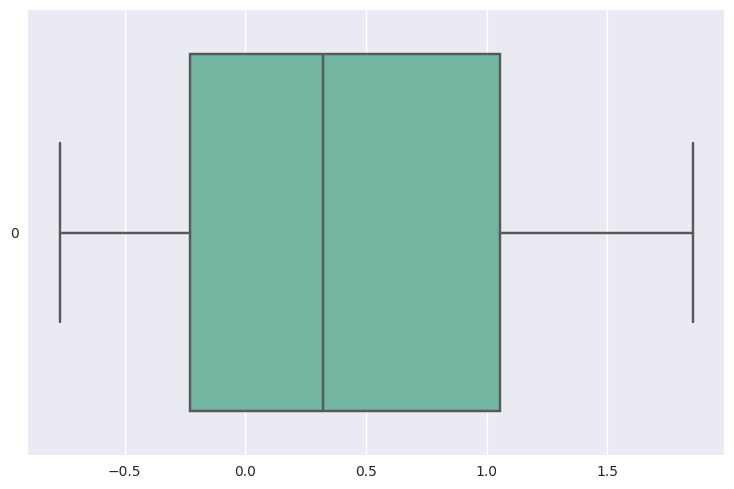

Column  Cholesterol


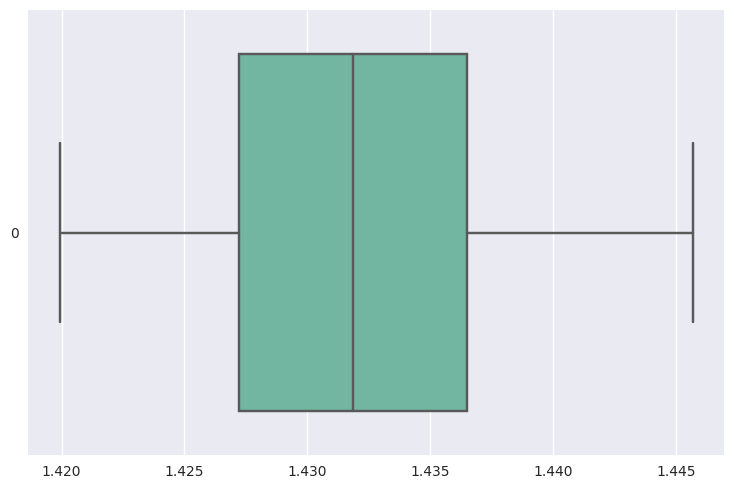

Column  Albumin


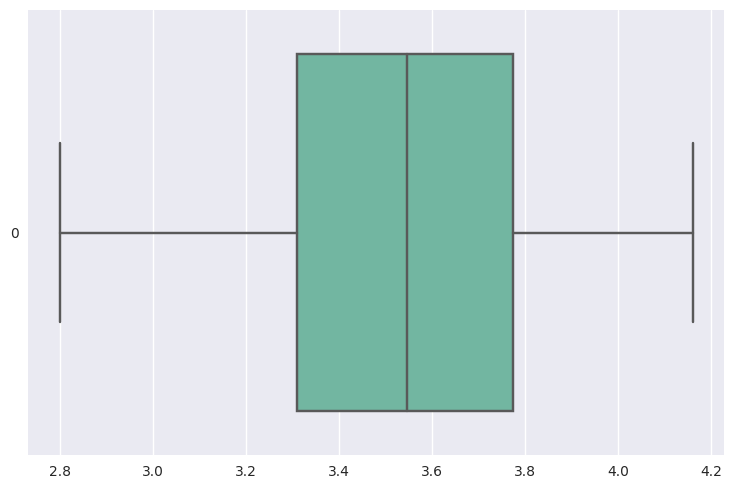

Column  Copper


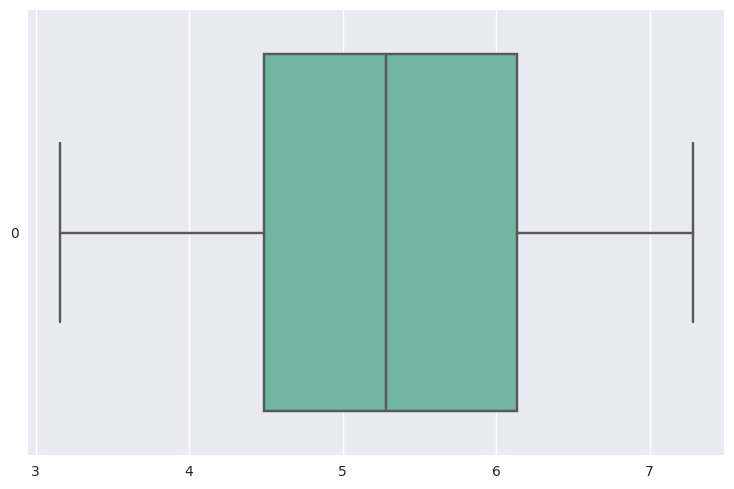

Column  Alk_Phos


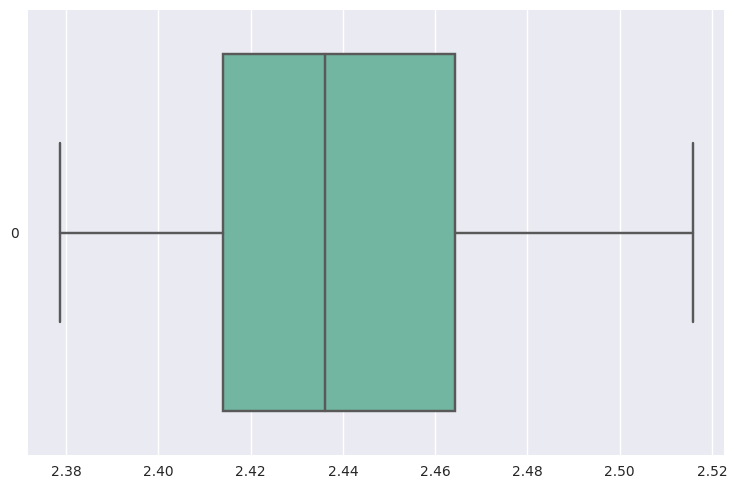

Column  SGOT


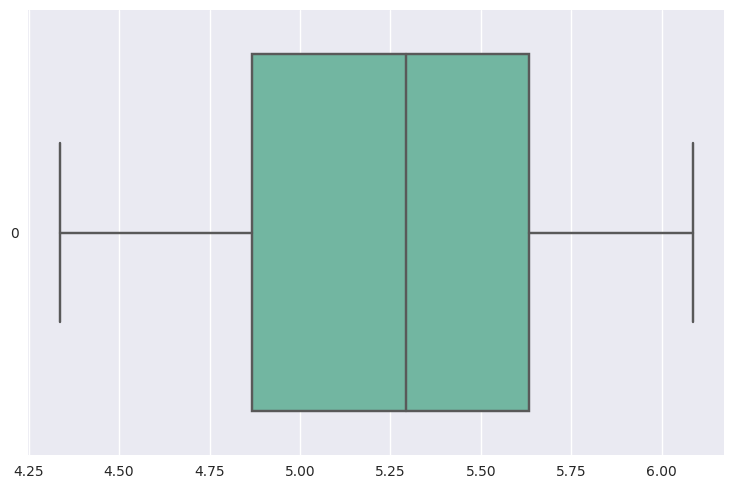

Column  Tryglicerides


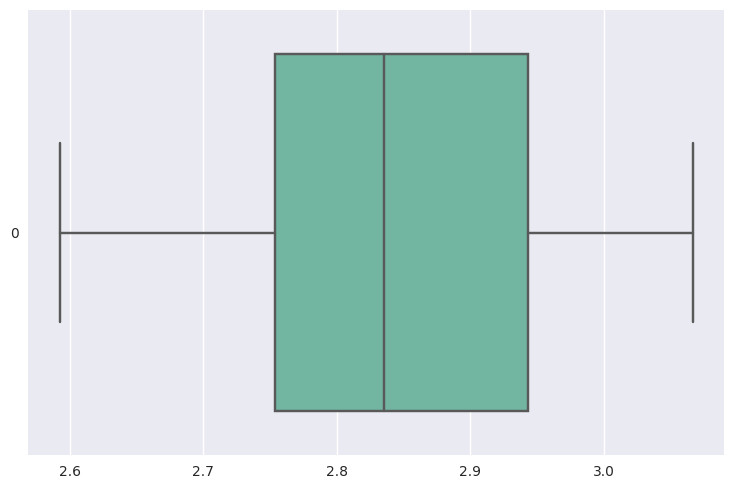

Column  Platelets


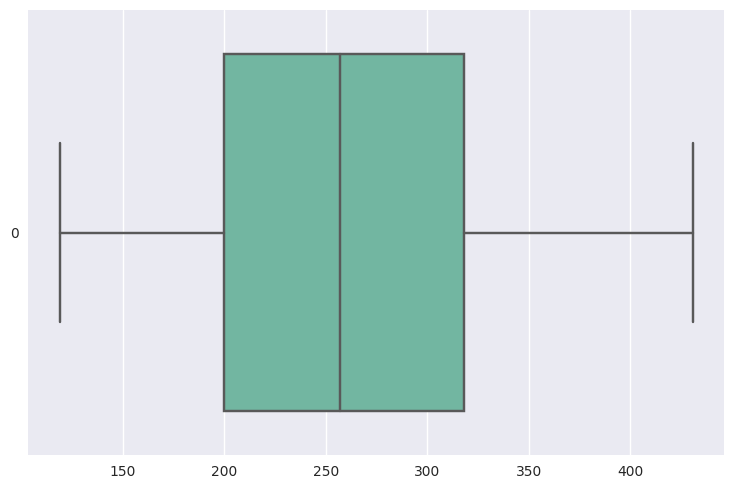

Column  Prothrombin


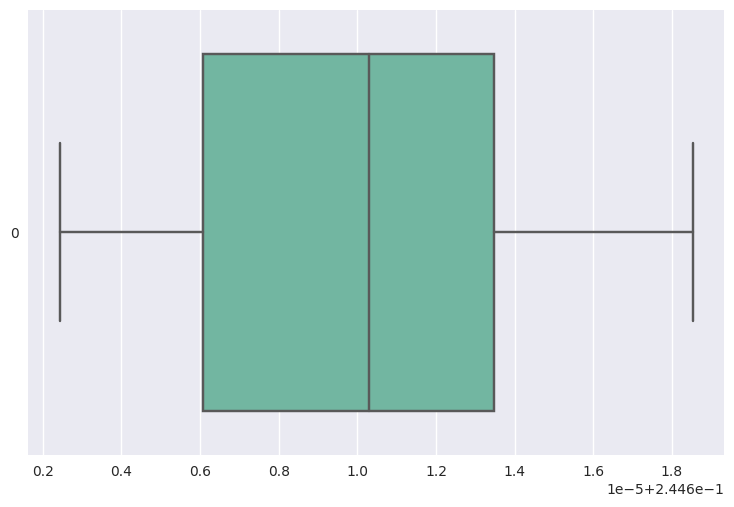

Column  Drug


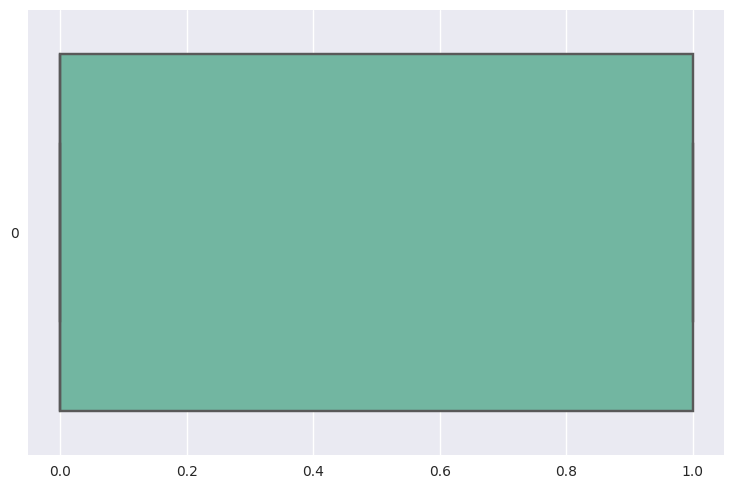

Column  Sex


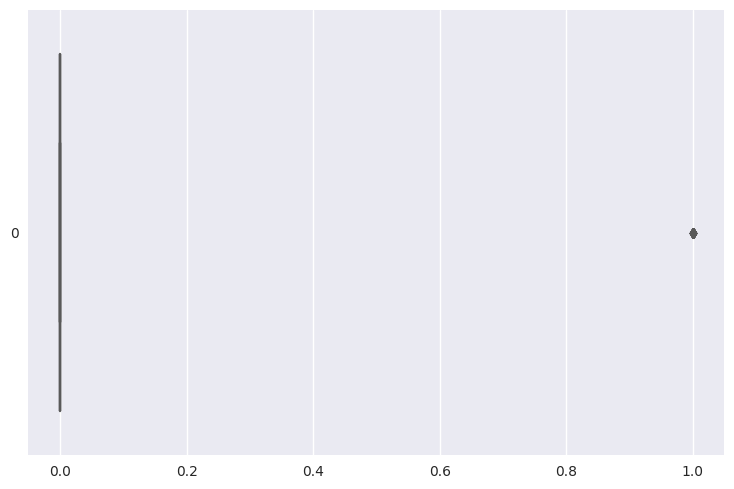

Column  Ascites


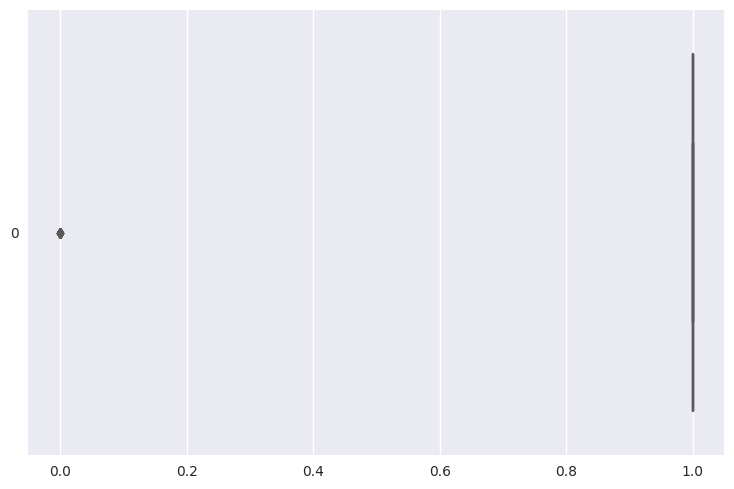

Column  Hepatomegaly


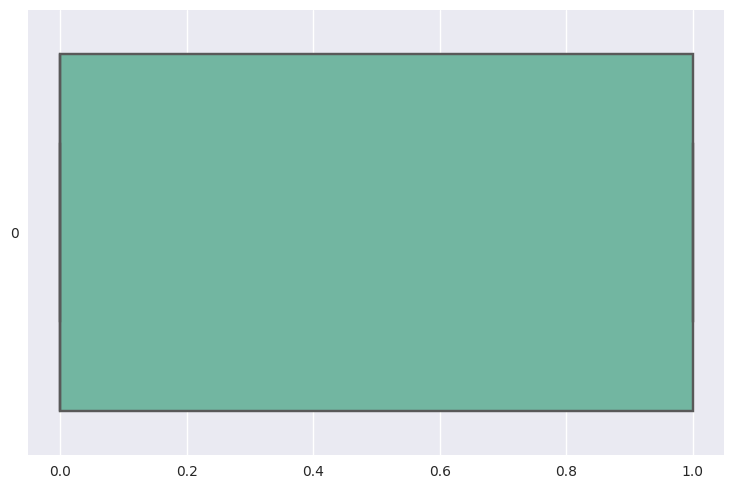

Column  Spiders


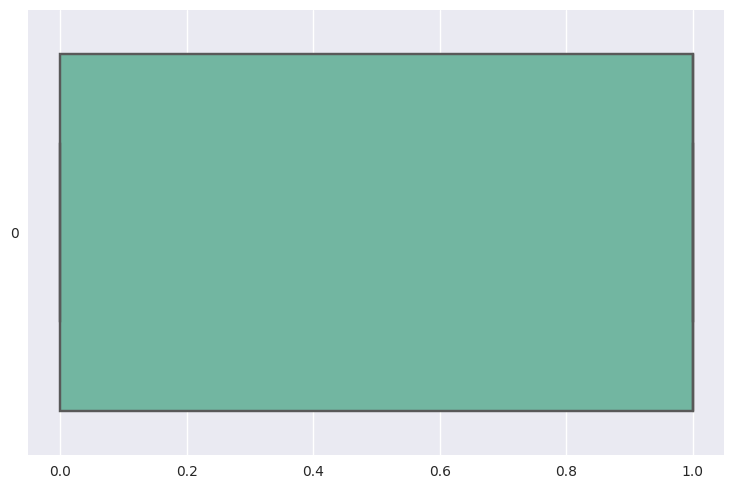

Column  Edema


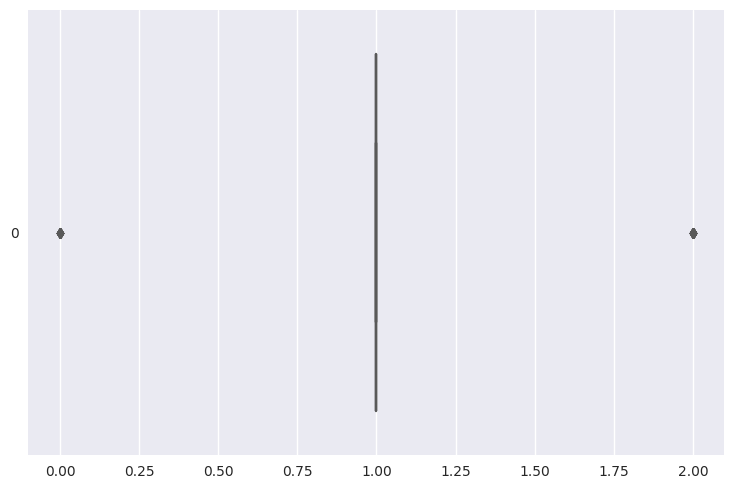

Column  Status


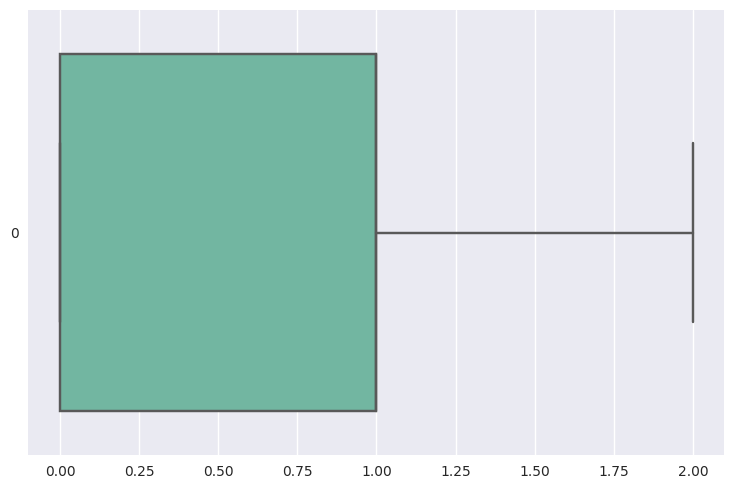

In [ ]:
# Tukey Rule outliers
# As an alternative, you could use z-scores greater than 3 or less than -3.

cols = X.columns
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(X,i)
  print("Column ",i,": ",outliers_Tukey)
  
# Windsorize X and check the results
print("Descriptive Statistics Before", X.describe())
X_winsorized = X.copy(deep=True)
for i in cols:
  X_winsorized[i] = winsorize(X[i], limits=(0.05, 0.05))
print("Descriptive Statistics After", X_winsorized.describe())
for i in cols:
  print("Column ",i)
  ax = sns.boxplot(data=X_winsorized[i], orient="h", palette="Set2")
  plt.show()

## Address imbalance in the Target variable

In [ ]:
y.value_counts()

1    205
0     71
Name: Target, dtype: int64

In [ ]:
# SMOTE (oversampling)
# Data is unbalanced (38.54% converted instances)

import imblearn
print("imblearn version: ", imblearn.__version__)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12346)
X_SMOTE, y_SMOTE = sm.fit_resample(X_winsorized, y)

print("Shape before SMOTE: ", X.shape, y.shape, "\n")
print("Shape after SMOTE: ", X_SMOTE.shape, y_SMOTE.shape, "\n")

imblearn version:  0.10.1
Shape before SMOTE:  (276, 18) (276,) 

Shape after SMOTE:  (410, 18) (410,) 



# Additional data preparation(PCA)

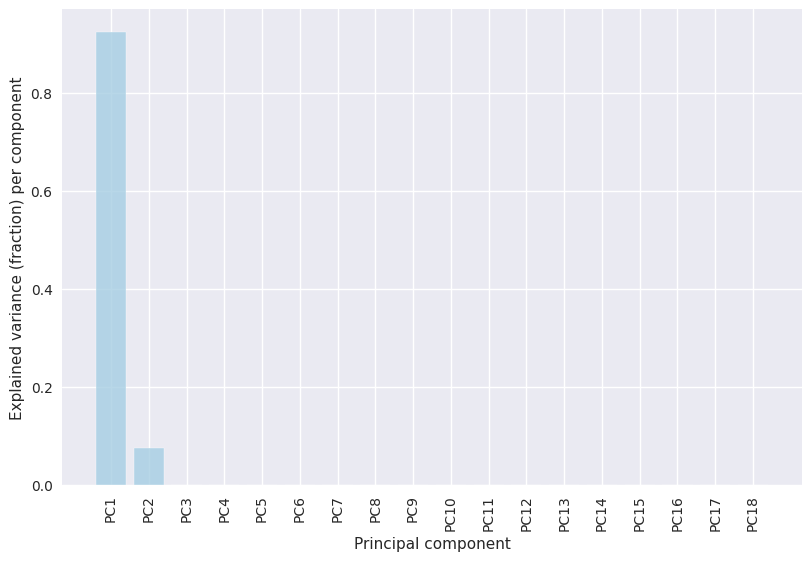

In [ ]:
from sklearn.decomposition import PCA
#stdsc = StandardScaler() 
#X_SMOTE = stdsc.fit_transform(X)

pca = PCA()
X_SMOTE_pca = pca.fit_transform(X_SMOTE)
pca.explained_variance_ratio_

pca_explained_variance_bar(pca, alpha=0.8)
plt.show()

X_SMOTE_pca = pd.DataFrame(X_SMOTE_pca)
#X_SMOTE_pca.columns = col_names

<BarContainer object of 18 artists>

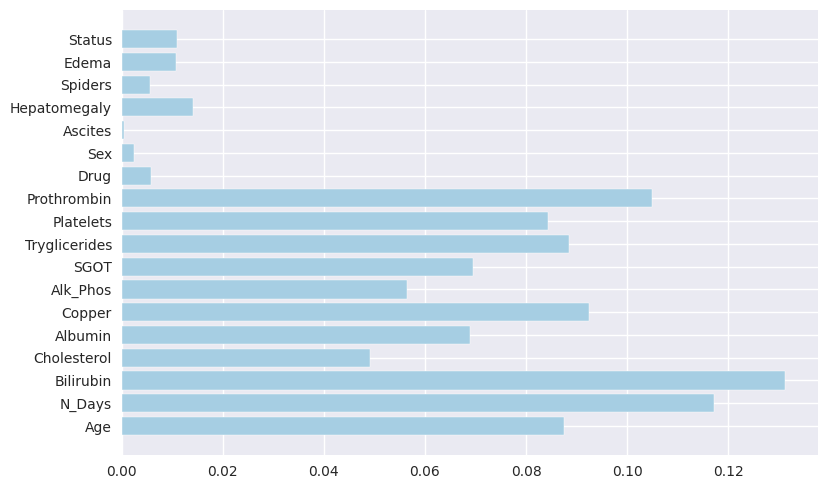

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_SMOTE, y_SMOTE)
plt.barh(X_SMOTE.columns, rf.feature_importances_)